The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

# RMSProp算法
:label:`sec_rmsprop`

 :numref:`sec_adagrad`中的关键问题之一，是学习率按预定时间表$\mathcal{O}(t^{-\frac{1}{2}})$显著降低。
虽然这通常适用于凸问题，但对于深度学习中遇到的非凸问题，可能并不理想。
但是，作为一个预处理器，Adagrad算法按坐标顺序的适应性是非常可取的。

 :cite:`Tieleman.Hinton.2012`建议以RMSProp算法作为将速率调度与坐标自适应学习率分离的简单修复方法。
问题在于，Adagrad算法将梯度$\mathbf{g}_t$的平方累加成状态矢量$\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$。
因此，由于缺乏规范化，没有约束力，$\mathbf{s}_t$持续增长，几乎上是在算法收敛时呈线性递增。

解决此问题的一种方法是使用$\mathbf{s}_t / t$。
对$\mathbf{g}_t$的合理分布来说，它将收敛。
遗憾的是，限制行为生效可能需要很长时间，因为该流程记住了值的完整轨迹。
另一种方法是按动量法中的方式使用泄漏平均值，即$\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$，其中参数$\gamma > 0$。
保持所有其它部分不变就产生了RMSProp算法。

## 算法

让我们详细写出这些方程式。

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

常数$\epsilon > 0$通常设置为$10^{-6}$，以确保我们不会因除以零或步长过大而受到影响。
鉴于这种扩展，我们现在可以自由控制学习率$\eta$，而不考虑基于每个坐标应用的缩放。
就泄漏平均值而言，我们可以采用与之前在动量法中适用的相同推理。
扩展$\mathbf{s}_t$定义可获得

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

同之前在 :numref:`sec_momentum`小节一样，我们使用$1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$。
因此，权重总和标准化为$1$且观测值的半衰期为$\gamma^{-1}$。
让我们图像化各种数值的$\gamma$在过去40个时间步长的权重。


**RMSProp 提出的核心动机就是改进 AdaGrad 在非凸优化中学习率过度衰减的问题，通过泄漏平均让学习率调整更灵活，更好适配深度学习的非凸损失优化需求 **

In [1]:
import math
import torch
from d2l import torch as d2l

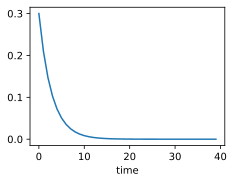

In [9]:
d2l.set_figsize()
#gammas = [0.95, 0.9, 0.8, 0.7]
gammas = [0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma3 = {gamma:.2f}')
d2l.plt.xlabel('time');

## 从零开始实现

和之前一样，我们使用二次函数$f(\mathbf{x})=0.1x_1^2+2x_2^2$来观察RMSProp算法的轨迹。
回想在 :numref:`sec_adagrad`一节中，当我们使用学习率为0.4的Adagrad算法时，变量在算法的后期阶段移动非常缓慢，因为学习率衰减太快。
RMSProp算法中不会发生这种情况，因为$\eta$是单独控制的。


epoch 20, x1: -0.000145, x2: -0.007692


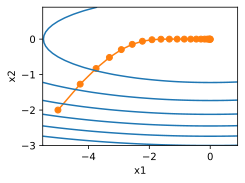

In [17]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.7
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

接下来，我们在深度网络中实现RMSProp算法。


In [18]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

In [19]:
def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

我们将初始学习率设置为0.01，加权项$\gamma$设置为0.9。
也就是说，$\mathbf{s}$累加了过去的$1/(1-\gamma) = 10$次平方梯度观测值的平均值。


loss: 0.245, 0.184 sec/epoch


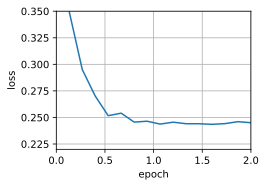

In [20]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

## 简洁实现

我们可直接使用深度学习框架中提供的RMSProp算法来训练模型。


loss: 0.243, 0.197 sec/epoch


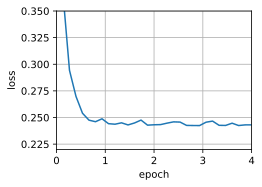

In [21]:
trainer = torch.optim.RMSprop
d2l.train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

## 小结

* RMSProp算法与Adagrad算法非常相似，因为两者都使用梯度的平方来缩放系数。
* RMSProp算法与动量法都使用泄漏平均值。但是，RMSProp算法使用该技术来调整按系数顺序的预处理器。
* 在实验中，学习率需要由实验者调度。
* 系数$\gamma$决定了在调整每坐标比例时历史记录的时长。

## 练习

1. 如果我们设置$\gamma = 1$，实验会发生什么？为什么？
1. 旋转优化问题以最小化$f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$。收敛会发生什么？
1. 试试在真正的机器学习问题上应用RMSProp算法会发生什么，例如在Fashion-MNIST上的训练。试验不同的取值来调整学习率。
1. 随着优化的进展，需要调整$\gamma$吗？RMSProp算法对此有多敏感？


[Discussions](https://discuss.d2l.ai/t/4322)
